In [75]:
%%time
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

Wall time: 0 ns


In [40]:
df = pd.read_csv('Microsoft_Stock.csv',infer_datetime_format=True, parse_dates=['Date'], index_col='Date')\

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [22]:
df.shape


(1511, 5)

In [381]:
dfts = df['Close'].resample('5d').mean()

In [127]:
if df.Close.isnull().sum() == 0: print(df.shape)

(1511, 5)


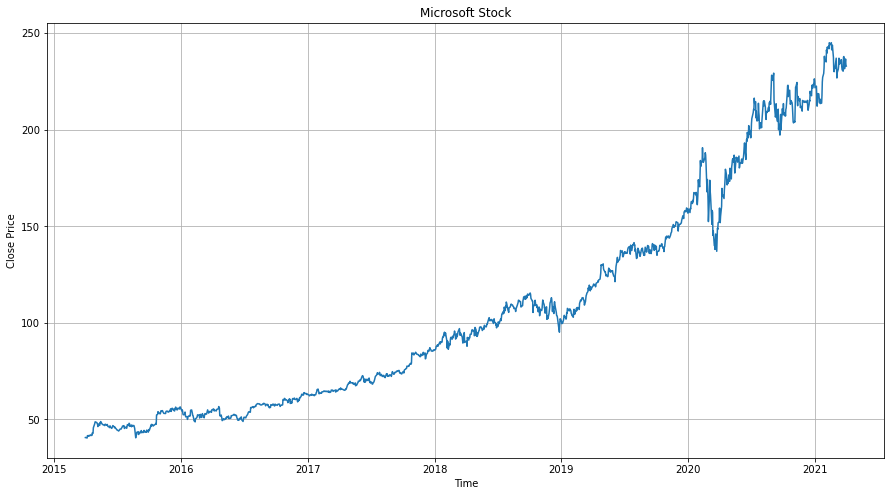

In [128]:
plt.figure(figsize = (15,8))
plt.plot(df.Open)
plt.title('Microsoft Stock')
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

In [180]:
tsclose = df['Close']

In [114]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [115]:
# Time Series Components and Stationarity Test
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

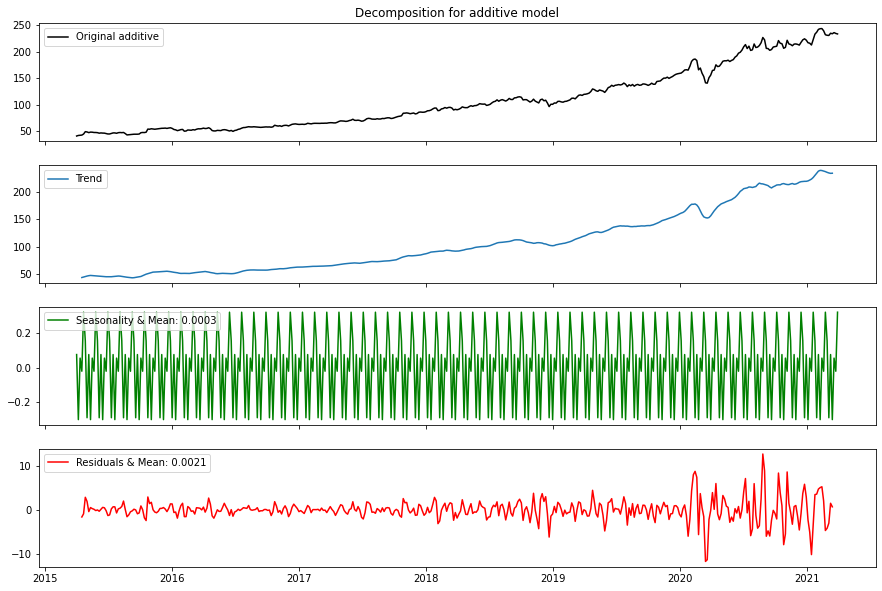

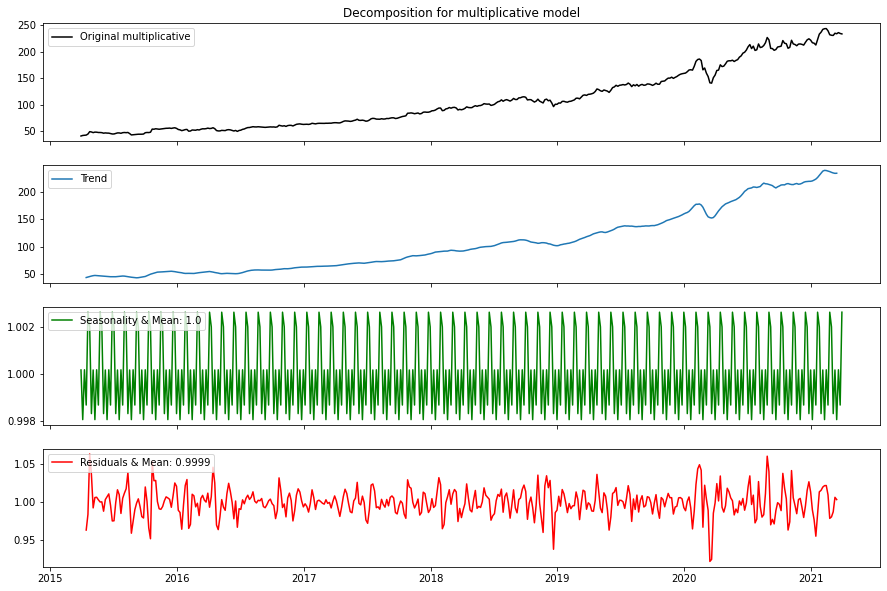

In [116]:
# Analysis for additive and multiplicative models
for model in ["additive", "multiplicative"]:
    ts_decompose(dfts, model)

In [160]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend", color = 'b')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", color="#F4b41a")
    plt.legend(loc="upper left")
    plt.grid(True)

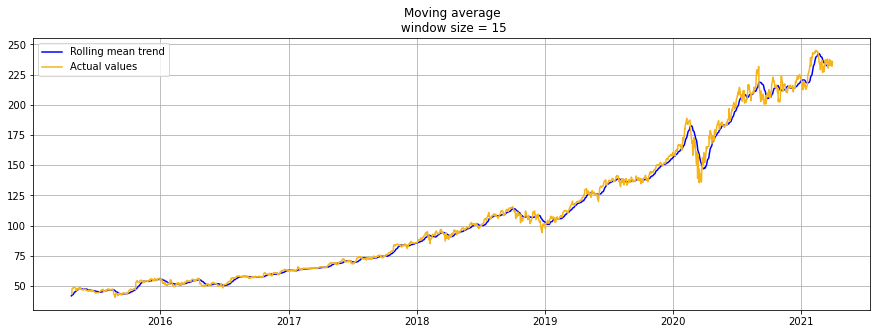

In [161]:
plotMovingAverage(df.Close, 15) 

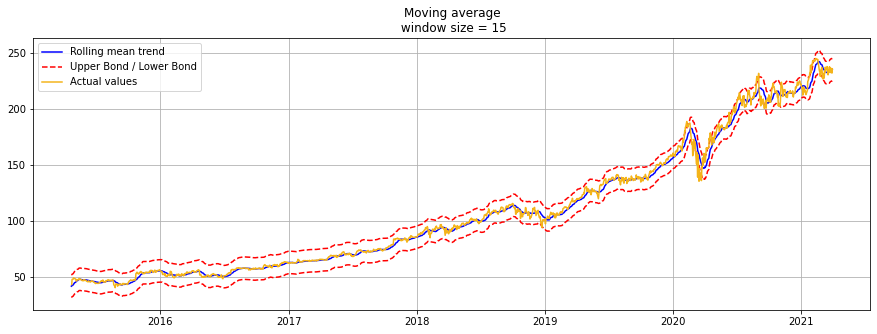

In [168]:

plotMovingAverage(df.Close, 15, plot_intervals=True)

In [173]:
pip install pmdarima

     -------------------------------------- 603.1/603.1 KB 9.4 MB/s eta 0:00:00
     ------------------------------------- 983.8/983.8 KB 31.4 MB/s eta 0:00:00
  Using cached urllib3-1.26.8-py2.py3-none-any.whl (138 kB)
Note: you may need to restart the kernel to use updated packages.


(-0.22249502796939352, 0.9357866106447721, 1, 437, {'1%': -3.4454029241336483, '5%': -2.8681766097362087, '10%': -2.570305075326362}, -2005.1926786967956)
Log transform stationary check p value:  0.9357866106447721

 (-18.783825495507863, 2.0240089144265475e-30, 0, 437, {'1%': -3.4454029241336483, '5%': -2.8681766097362087, '10%': -2.570305075326362}, -2001.370063592772)

First order difference stationary check p value:  2.0240089144265475e-30


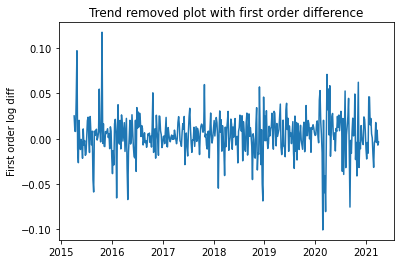

In [400]:
from statsmodels.tsa.stattools import adfuller
#log transform
train_log= np.log(dfts)
train_log.dropna(inplace = True)

s_test = adfuller(train_log, autolag= 'AIC')
print(s_test)
print('Log transform stationary check p value: ', s_test[1])

#take first difference
train_log_diff = train_log - train_log.shift()
train_log_diff.dropna(inplace= True)
plt.title('Trend removed plot with first order difference')
plt.plot(train_log_diff)
plt.ylabel('First order log diff')

s_test = adfuller(train_log_diff, autolag= 'AIC')
print('\n', s_test)
print('\nFirst order difference stationary check p value: ', s_test[1])

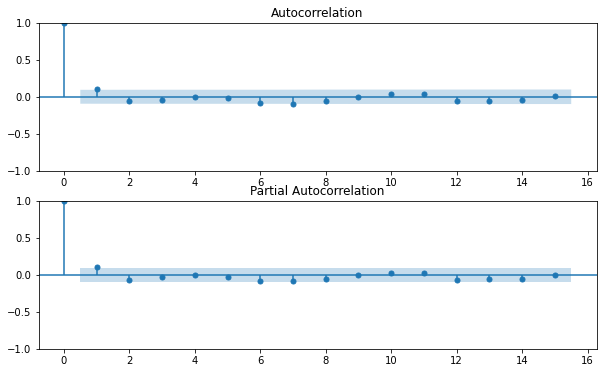

In [401]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(10,6))
fig = sm.graphics.tsa.plot_acf(train_log_diff.dropna(), lags=15, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_log_diff.dropna(), lags=15, ax=ax[1])
plt.show()

In [472]:
from sklearn import metrics
#build model
model = sm.tsa.SARIMAX(train_log, order= (7,2,7))
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())
train_log_predict = results_ARIMA.predict()

#evaluate model
print('AIC: ', results_ARIMA.aic)
print('BIC: ', results_ARIMA.bic)
print('Mean absolute Error: ', metrics.mean_absolute_error(train_log, train_log_predict))
print('Root mean absolute error: ', np.sqrt(metrics.mean_absolute_error(train_log, train_log_predict)))

#check autocorrelation
print('Durbin-watson statistic: ', sm.stats.durbin_watson(results_ARIMA.resid))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  439
Model:               SARIMAX(7, 2, 7)   Log Likelihood                1038.602
Date:                Sat, 05 Mar 2022   AIC                          -2047.205
Time:                        14:20:55   BIC                          -1986.006
Sample:                    04-01-2015   HQIC                         -2023.055
                         - 03-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2997      1.324     -0.981      0.326      -3.895       1.296
ar.L2         -0.9994      1.243     -0.804      0.421      -3.435       1.436
ar.L3         -1.0626      1.586     -0.670      0.5

In [446]:
print(train.tail(1), test.tail(2))


Date
2020-08-10 16:00:00    208.25
Name: Close, dtype: float64 Date
2021-03-30 16:00:00    231.85
2021-03-31 16:00:00    235.77
Name: Close, dtype: float64


Text(0, 0.5, 'Price')

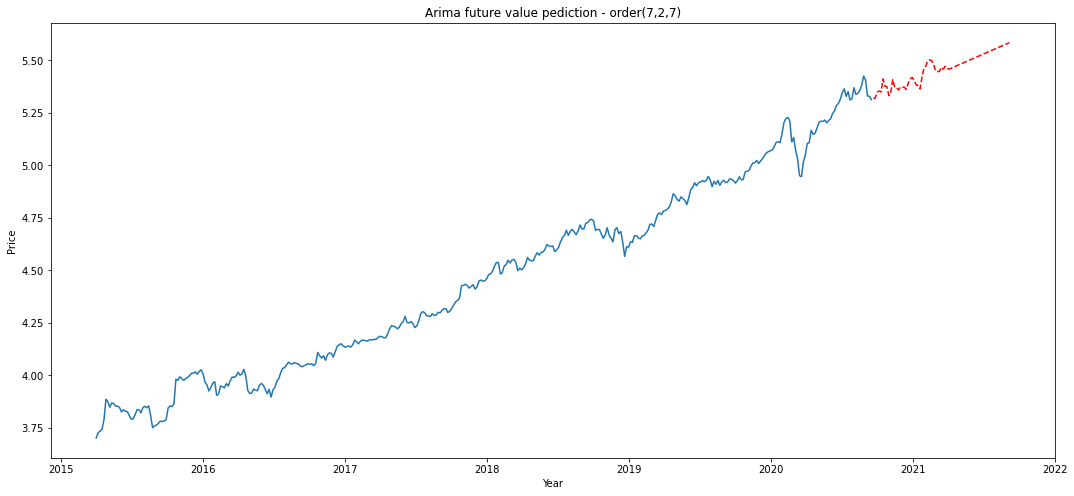

In [470]:

prediction = results_ARIMA.predict(start=400,end=470)
plt.figure(figsize= (18,8))
plt.title('Arima future value pediction - order(7,2,7)')
plt.plot(train_log[:400], label='Actual')
plt.plot(prediction, 'r--', label= 'predicted')
plt.xlabel('Year')
plt.ylabel('Price')